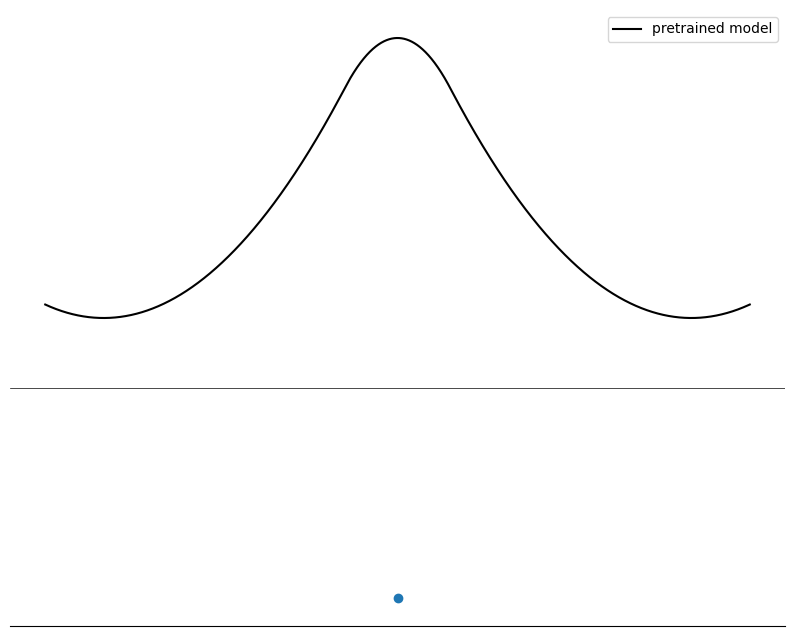

In [34]:
import numpy as np
from scipy.interpolate import BSpline, make_interp_spline
import matplotlib.pyplot as plt

# Given x and y values
x_interp = np.array([-5, -1.8, 0, 1.8, 5])
y_interp = np.array([0, 1, 2, 1, 0])

# Define the order of the spline
k = 2  # for a quintic (5th order) spline
# Create a B-spline interpolation
f_PT = make_interp_spline(x_interp, y_interp, k=k)


# Generate new x values for plotting
x = np.linspace(min(x_interp)-1, max(x_interp)+1, 10001)

# Generate interpolated y values
y_PT = f_PT(x)


second_axis_y = -0.5
# Plot the original points and the interpolated curve
fig,ax = plt.subplots(1,figsize = (10,8))
ax.plot(x, y_PT, '-', color='k', label='pretrained model')

ax.axhline(y=second_axis_y, color='k', linestyle='-',linewidth=0.5)
ax.scatter([0],[-2])

ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.legend()
plt.show()

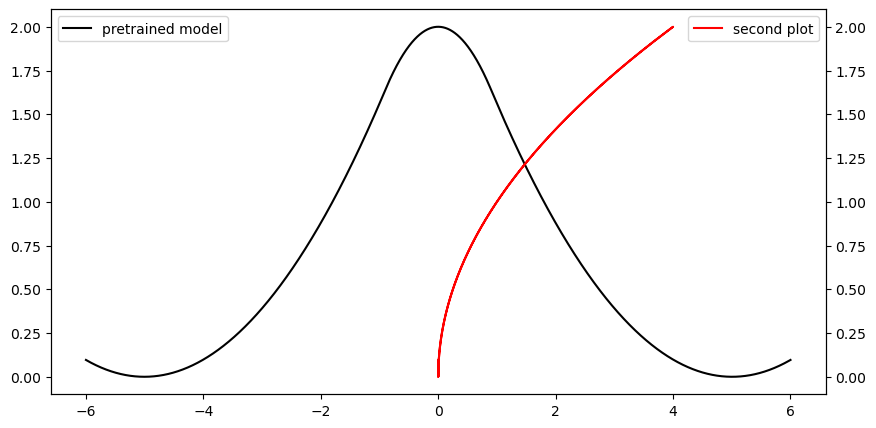

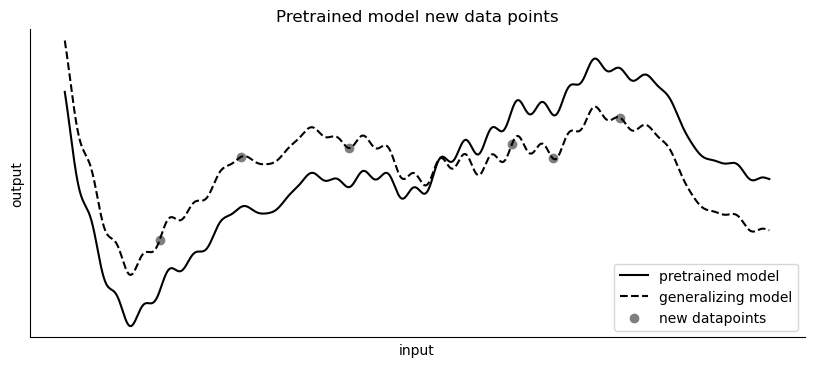

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange, UnivariateSpline
from scipy.signal import tukey
from scipy.interpolate import CubicSpline

fig,ax = plt.subplots(1,figsize = (10,4))
# ax.set_aspect(0.2)
SCENARIO = 'generalizing'
# SCENARIO = 'underfitting'
# SCENARIO = 'overfitting'


x = np.linspace(-3.1,2.1,10001)

## Pretrained model
def polynomial(coefficients, x):
    y = np.zeros_like(x)
    for degree, coeff in enumerate(coefficients):
        y+= coeff * x ** degree
    return y
coefficients = np.array([12,28,11,-14,-8,2,1])
poly = lambda x: polynomial(coefficients/10,x)
noise = lambda x: 1/2 * np.sin(x*9)*np.sin(x*3) + 1/8* np.sin(32*x) +  1/8 * np.sin(34*x) 
f_PT = lambda x: poly(x) + noise(x)

## Plot pretrained model
y_PT = f_PT(x)
ax.plot(
    x,
    y_PT,
    color='k',
    label="pretrained model")

## New true distribution
def diff_function(x):
    y = 1/(1+np.exp(3*x+1))
    y = 3*(y-0.5)
    return y
f_true = lambda x: f_PT(x) + diff_function(x)
y_true = f_true(x)

## New data points
x_samples = np.array([-2.4, -1.8, -1, 0.2, 0.5,1])
y_samples = f_true(x_samples)

## Underfitting
# Interpolate the data points
x_interp = np.sort(np.append(x_samples, np.array([-3,-2.6,1.4,2])))
f_underfitting = UnivariateSpline(x_interp, f_true(x_interp))
# interpolation = lagrange(x_samples, y_samples)
y_underfitting = f_underfitting(x)


## Overfitting 
x_range = 0.1

# Sort x_samples and y_samples
sort_indices = np.argsort(x_samples)
x_samples = np.array(x_samples)[sort_indices]
y_samples = np.array(y_samples)[sort_indices]

# Define ranges
ranges = [(x - x_range, x + x_range) for x in x_samples]

# Create spline functions
splines = []
for i, (start, end) in enumerate(ranges):
    x_range_values = np.linspace(start, end, 100)
    # Create a spline that interpolates between f_PT at the range edges and y_samples[i] at x_samples[i]
    y_range_values = np.array([f_PT(start), y_samples[i], f_PT(end)])
    x_spline_values = np.array([start, x_samples[i], end])
    spline = CubicSpline(x_spline_values, y_range_values)
    splines.append(spline)

# Define the piecewise function
def piecewise_spline(x):
    for i, (start, end) in enumerate(ranges):
        if start <= x <= end:
            return splines[i](x)
    return f_PT(x)
piecewise_spline__vec = np.vectorize(piecewise_spline)

if SCENARIO == 'overfitting':
    ## Plot the overfitting model
    for i, (start, end) in enumerate(ranges):
        mask = np.logical_and(start <= x, x <= end)
        x_overfitting = x[mask]
        y_overfitting = piecewise_spline__vec(x_overfitting)
        label = "overfitting model" if i == 0 else None  # Only add the label for the first subplot
        ax.plot(
            x_overfitting,
            y_overfitting,
            color='k',
            linestyle=':',
            label=label
        )

if SCENARIO == 'generalizing':
    ## Plot the generalizing model
    ax.plot(
        x,
        y_true,
        linestyle='--',
        color='k',
        label="generalizing model"
    )

if SCENARIO == 'underfitting':
    ## Plot the underfitting model
    ax.plot(
        x,
        y_underfitting,
        linestyle=':',
        color='k',
        label="underfitting model"
    )

## Plot new data points
ax.scatter(x_samples,y_samples,label="new datapoints",c="tab:gray")


ax.legend()

ax.set_xlabel('input')
ax.set_ylabel('output')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylim([-4.5,4.5])


# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_title("Pretrained model new data points")
fig.savefig(f"fumbrella_motivation_{SCENARIO}.pdf")

C:\Users\Valentin\AppData\Local\Temp\ipykernel_21624\848218356.py:2: DeprecationWarning: Importing tukey from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.tukey' or the convenience function 'scipy.signal.get_window' instead.
  f_window = lambda x: tukey(len(x), alpha=0.6)


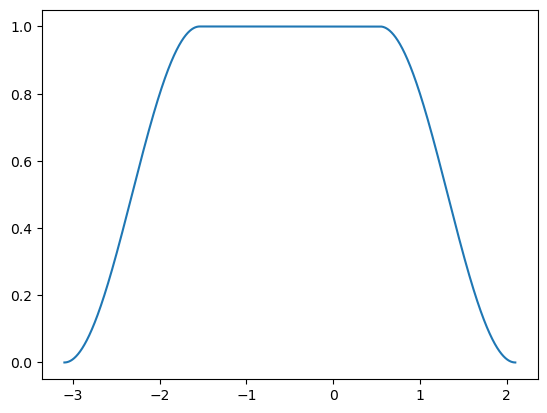

In [71]:
from scipy.signal import tukey
f_window = lambda x: tukey(len(x), alpha=0.1)
plt.plot(x,f_window(x))


[-2.   -1.   -0.3   0.5   1.   -2.5  -1.5  -0.65  0.1   0.75  1.5 ]
[ 1.47992145  1.14239123 -0.07493756 -1.27242546 -1.44604137 -3.52143626
 -0.52651741 -0.24031526  1.5979698   3.20214511  1.26891892]
[-2.5  -2.   -1.5  -1.   -0.65 -0.3   0.1   0.5   0.75  1.    1.5 ]
[-3.52143626  1.47992145 -0.52651741  1.14239123 -0.24031526 -0.07493756
  1.5979698  -1.27242546  3.20214511 -1.44604137  1.26891892]


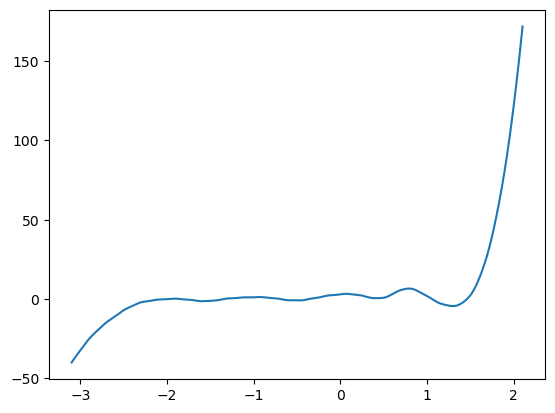

In [3]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange, CubicSpline


x_1 = np.array([-2.5,-1.5,-0.65,0.1,0.75,1.5])
y_1 = f_PT(x_1)

x_interp = np.concatenate([x_samples,x_1])
print(x_interp)
y_interp = np.concatenate([y_diff,y_1])
print(y_interp)
idx = x_interp.argsort()
x_interp = x_interp[idx]
print(x_interp)
y_interp = y_interp[idx]
print(y_interp)


# poly = lagrange(x_interp, y_interp)
# f_overfit = lambda x: Polynomial(poly.coef[::-1])(x)
cs = CubicSpline(x_interp,y_interp)
f_overfit = lambda x:  cs(x) + f_PT(x)
y_overfit = f_overfit(x)
plt.plot(x,y_overfit)

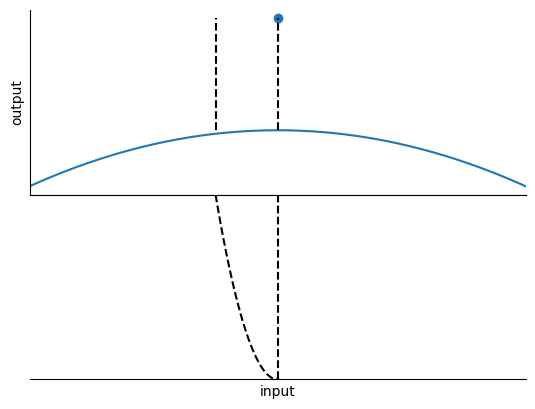

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
from scipy.interpolate import lagrange

fig, (ax0,ax1) = plt.subplots(2,1)
# ax.set_aspect(0.33)

interval = [-4,4]
x_no_dropout = np.array([0.0])
x_with_dropout = np.array([-1.0])
x = np.linspace(interval[0],interval[1],10001)
y_gap = 0.1

def polynomial(coefficients, x):
    y = np.zeros_like(x)
    for degree, coeff in enumerate(coefficients):
        y+= coeff * x ** degree
    return y
coefficients = np.array([0,0,-1/32])
poly = lambda x: polynomial(coefficients,x)
f_PT = lambda x: poly(x)

# TOP AXIS
y_PT = f_PT(x)
ax0.plot(x,y_PT,label="pretrained model")
y_no_dropout_pretrained = f_PT(x_no_dropout)
y_no_dropout_finetuned = f_PT(x_no_dropout)+1
ax0.scatter(
    x_no_dropout,
    y_no_dropout_finetuned,
    label="new datapoint"
    )

ax0.vlines(
    x=x_no_dropout,
    ymin=y_no_dropout_pretrained,
    ymax=y_no_dropout_finetuned,
    colors="k",
    linestyles="dashed"
    )

ax0.vlines(
    x=x_with_dropout,
    ymin=y_no_dropout_pretrained,
    ymax=y_no_dropout_finetuned,
    colors="k",
    linestyles="dashed"
    )

ax.annotate('input representation', xy=(1,0), xytext=(5, 1), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
ax0.set_ylabel('output')
ax0.set_yticklabels([])
ax0.set_xticklabels([])
ax0.set_xticks([])
ax0.set_yticks([])
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)
ax0.set_xlim(interval)
# ax0.set_ylim([y_no_dropout_pretrained.min()-y_gap,y_no_dropout_finetuned.max()])



# BOTTOM AXIS
l = ax1.vlines(x=x_no_dropout,ymin=0,ymax=1,colors="k",linestyles="dashed")
# l.set_dashes

x_temp = np.linspace(x_with_dropout,x_no_dropout,101)
y_temp = x_temp**2
plt.plot(x_temp,y_temp,c="k",linestyle="dashed")

ax1.set_xlabel('input')
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines.left.set_visible(False)
ax1.spines.right.set_visible(False)
ax1.set_ylim([0,1])
ax1.set_xlim(interval)
# ax1.spines.top.set_visible(False)



fig.subplots_adjust(hspace=0)
# fig.tight_layout()